# CAB420 Assignment 2


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

# Define paths to your dataset
train_path = 'archive/train'
valid_path = 'archive/valid'
test_path = 'archive/test'

# ImageDataGenerator for loading images without augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse'
)

# Load the ResNet50 model pre-trained on ImageNet
def create_base_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

base_model = create_base_model()

# Function to compute the Euclidean distance between two embeddings
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sum_squared = tf.reduce_sum(tf.square(featsA - featsB), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_squared, tf.keras.backend.epsilon()))

# Function to build the Siamese network
def build_siamese_model(input_shape, base_model):
    inputA = Input(shape=input_shape)
    inputB = Input(shape=input_shape)
    
    featsA = base_model(inputA)
    featsB = base_model(inputB)
    
    distance = Lambda(euclidean_distance)([featsA, featsB])
    
    model = Model(inputs=[inputA, inputB], outputs=distance)
    return model

# Build the Siamese network
siamese_model = build_siamese_model((224, 224, 3), base_model)

# Define the contrastive loss
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile the Siamese network
siamese_model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])

# Custom data generator for creating pairs dynamically
class SiameseDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.generator.labels) / self.generator.batch_size))
    
    def __getitem__(self, index):
        batch_images, batch_labels = self.generator[index]
        pairs, labels = self.make_pairs(batch_images, batch_labels)
        return pairs, labels
    
    def on_epoch_end(self):
        self.generator.on_epoch_end()
    
    def make_pairs(self, images, labels):
        pair_images = []
        pair_labels = []
        
        num_classes = len(np.unique(labels))
        idx = [np.where(labels == i)[0] for i in range(num_classes)]
        
        for idxA in range(len(images)):
            current_image = images[idxA]
            label = int(labels[idxA])  # Ensure label is an integer
            
            # Debugging: print label and idx lengths
            print(f'label: {label}, len(idx): {len(idx)}')
            
            # Check if label is within range
            if label >= len(idx):
                print(f'Error: label {label} is out of range for idx')
                continue
            
            # Positive pair
            idxB = np.random.choice(idx[label])
            pos_image = images[idxB]
            
            pair_images.append([current_image, pos_image])
            pair_labels.append(1)
            
            # Negative pair
            neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
            idxB = np.random.choice(idx[neg_label])
            neg_image = images[idxB]
            
            pair_images.append([current_image, neg_image])
            pair_labels.append(0)
        
        return [np.array([pair[0] for pair in pair_images]), np.array([pair[1] for pair in pair_images])], np.array(pair_labels)

# Create SiameseDataGenerators for training and validation
train_pair_generator = SiameseDataGenerator(train_generator)
valid_pair_generator = SiameseDataGenerator(valid_generator)

# Train the model
history = siamese_model.fit(
    train_pair_generator,
    validation_data=valid_pair_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

# Evaluate the model
test_images, test_labels = [], []
for batch in test_generator:
    test_images.extend(batch[0])
    test_labels.extend(batch[1])
    if len(test_images) >= test_generator.samples:
        break

test_images = np.array(test_images)
test_labels = np.array(test_labels)

(pair_test, label_test) = train_pair_generator.make_pairs(test_images, test_labels)

test_loss, test_acc = siamese_model.evaluate([pair_test[0], pair_test[1]], label_test)
print(f'Test accuracy: {test_acc}')

print('Data loaded and processed successfully.')


## Visualise images

(5933, 128, 64, 3)
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


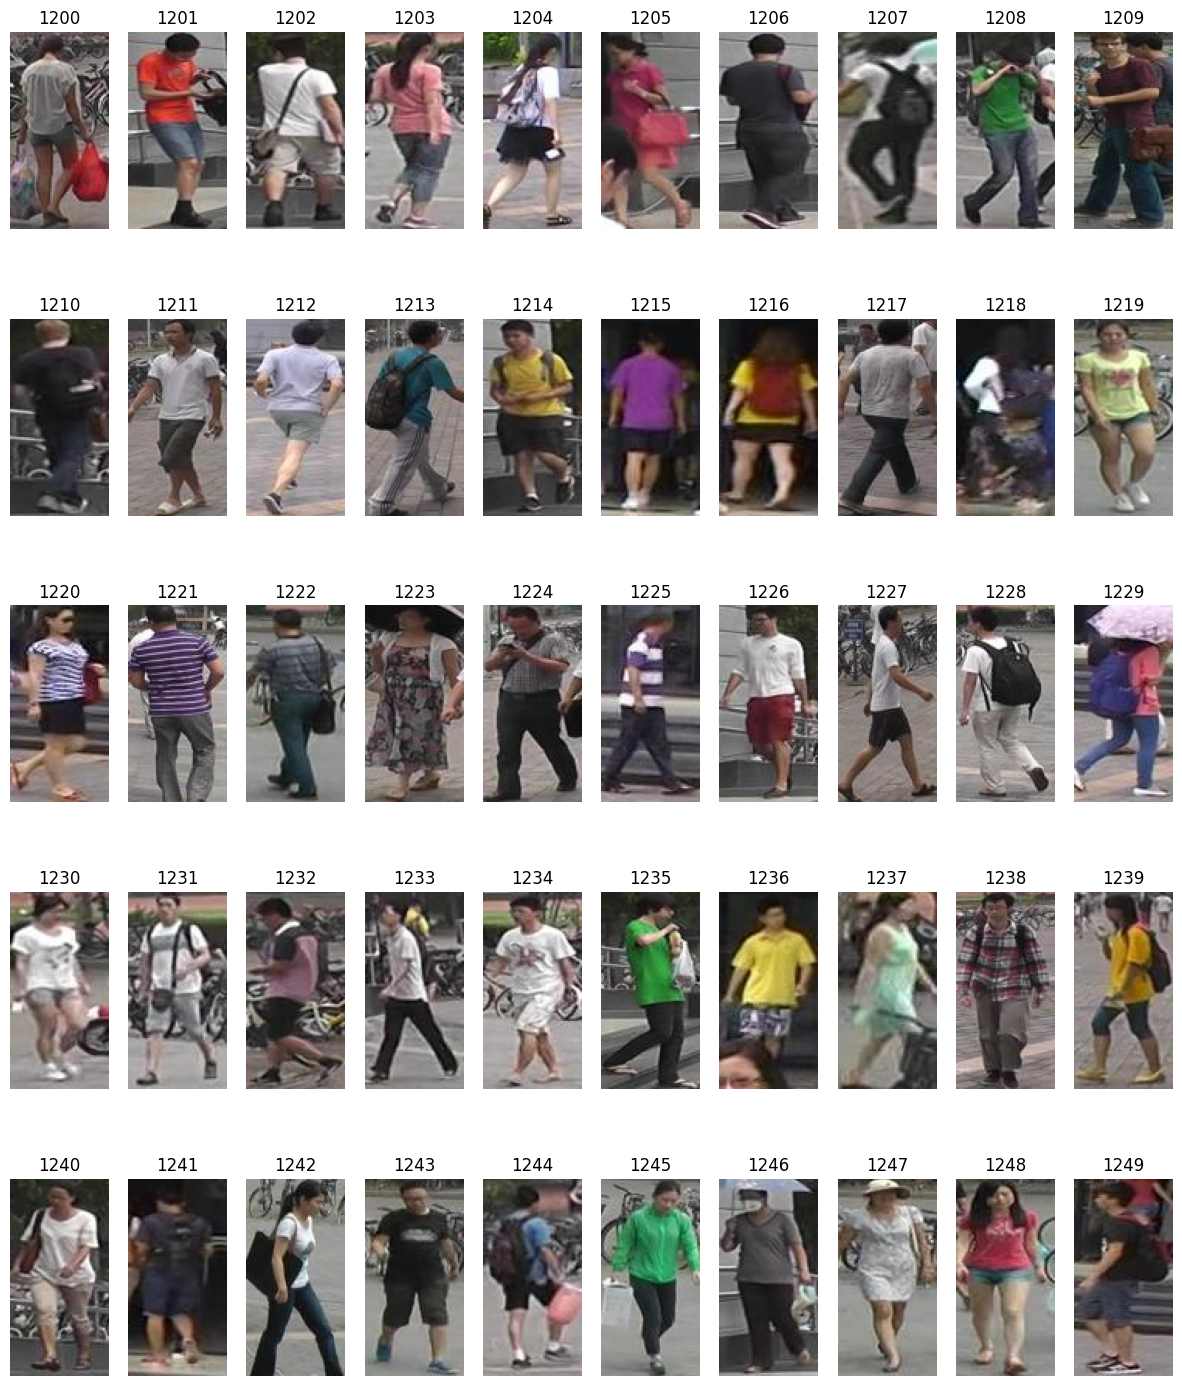

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define load_data function
def load_data(directory, image_size):
    data = []
    labels = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                image = load_img(file_path, target_size=image_size)
                image = img_to_array(image)
                data.append(image)
                labels.append(subdir)
    return np.array(data), np.array(labels)

# Example paths (update as needed)
train_path = 'archive/train'
valid_path = 'archive/valid'
test_path = 'archive/test'

# Load datasets with the desired image size
image_size = (224, 224)  # Example size, change as needed
X_train, y_train = load_data(train_path, image_size=image_size)
X_valid, y_valid = load_data(valid_path, image_size=image_size)
X_test, y_test = load_data(test_path, image_size=image_size)

# Counting images per class
class_image_count = {}

for subdir in os.listdir(train_path):
    subdir_path = os.path.join(train_path, subdir)
    if os.path.isdir(subdir_path):
        image_count = len(os.listdir(subdir_path))
        class_image_count[subdir] = image_count

# Print the number of images in each class
print("Number of images in each class:")
for class_name, count in class_image_count.items():
    print(f'{class_name}: {count} images')

# Find the class with the lowest and highest number of images
min_class = min(class_image_count, key=class_image_count.get)
max_class = max(class_image_count, key=class_image_count.get)

print(f'\nClass with the lowest number of images: {min_class} ({class_image_count[min_class]} images)')
print(f'Class with the highest number of images: {max_class} ({class_image_count[max_class]} images)')

# Plot class distribution
plt.figure(figsize=(20, 10))
plt.bar(class_image_count.keys(), class_image_count.values())
plt.xticks(rotation=90)
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Butterfly and Moths Dataset')
plt.show()

# Input parameters
classes_to_show = ['AN 88', 'ATALA', 'BROOKES BIRDWING']  # Replace with your class names
images_per_class = 8
rows = len(classes_to_show)
cols = 8

# Filter and sort images by specified classes and limits
def filter_and_sort_images(X, y, classes, images_per_class):
    filtered_images = []
    filtered_labels = []
    for class_name in classes:
        indices = [i for i, label in enumerate(y) if label == class_name]
        selected_indices = np.random.choice(indices, images_per_class, replace=False)
        for idx in selected_indices:
            filtered_images.append(X[idx])
            filtered_labels.append(y[idx])
    return np.array(filtered_images), np.array(filtered_labels)

# Visualize filtered images
def visualize_images(filtered_images, filtered_labels, rows, cols):
    plt.figure(figsize=(20, 10))
    for i in range(len(filtered_images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(filtered_images[i].astype("uint8"))
        plt.title(filtered_labels[i])
        plt.axis("off")
    plt.show()

filtered_images, filtered_labels = filter_and_sort_images(X_train, y_train, classes_to_show, images_per_class)
visualize_images(filtered_images, filtered_labels, rows, cols)



print('Data loaded and processed successfully.')
